# FFT-FFN Model 

Build a FeedForward Network to learn a representation of the Fourier transformed Time Series Data (presumably built to learn/recreate signals without the time series component in LSTMs)


<BR>


**Links + Resources**
- Autoencoder Example- https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder (uses a combination of model and sequential APIs in tf)
- Interpretation of Fourier Amplitudes- https://dsp.stackexchange.com/questions/62908/interpreting-the-amplitude-of-signals-in-fourier-transform (background information, useful to think about)



In [218]:
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

from StockData import * 


# Read in LSTM Specific Data 
stock_data = "../Data Quality (Stocks)/Stocks_Cleaned.csv"
WINDOW_LEN = 20 #number of days to pull data for, test set size, reshape in MinMaxScaler

X_train, y_train, X_test, y_test = getData(data_path=stock_data #returns arbitrary number of samples as specified in read data file, var="n_samples"
                                          , n_days=WINDOW_LEN, column="volume", ticker="AAPL", n_samples=10_000)

X_total, y_total = getHistoricalData(data_path=stock_data, n_days=WINDOW_LEN, column="volume", ticker="AAPL", normalize=False)


# Reshape on Read in
X_train = X_train.reshape(len(X_train), 20)
X_test = X_test.reshape(len(X_test), 20)
X_total = X_total.reshape(len(X_total), 20)
print("Updated Sequence Dims")
print(X_train.shape)
print(X_test.shape)
print(X_total.shape)


Train - Data-(9980, 1, 20) Labels-(9980,)
 Test - Data-(20, 1, 20) Labels-(20,)
Hist. - Data-(1284, 1, 20) Labels-(1284,)
Updated Sequence Dims
(9980, 20)
(20, 20)
(1284, 20)


In [200]:
# Numpy Variant of FFT- https://stackoverflow.com/questions/51298604/calculating-amplitude-from-np-fft
from numpy.fft import fft

n_samples = len(X_train)
xft = fft(X_train, axis=2) #defaults to last axis, specify to time series data (applies to each array per day in data)
# xft = xft.reshape(9980, 20)
amp = 2/n_samples * np.abs(xft)

amp.shape
frequencies = np.fft.fftfreq(n_samples) * n_samples * 1 / (1 - 0)

print("xft- ", xft.shape)
print("amp- ", amp.shape)
xft[0]
amp[0]

xft-  (9980, 1, 20)
amp-  (9980, 1, 20)


array([[2.28351916e-04, 4.26437340e-05, 2.59048200e-05, 1.74573221e-05,
        1.80828910e-05, 1.99853176e-05, 3.01020293e-05, 2.37989107e-06,
        3.60335129e-06, 1.72017023e-05, 1.70602160e-05, 1.72017023e-05,
        3.60335129e-06, 2.37989107e-06, 3.01020293e-05, 1.99853176e-05,
        1.80828910e-05, 1.74573221e-05, 2.59048200e-05, 4.26437340e-05]])

In [ ]:
# Plot Above -- A bit noisy

plt.subplot(2, 1, 1)
xs = np.linspace(0, 1, 9980)
plt.plot(xs, y_train.reshape(9980))
plt.title("Supposed Sine Wave")

plt.subplot(2, 1, 2)
plt.semilogx(frequencies[:len(frequencies) // 2], amp[:len(xft) // 2])
plt.title("Alleged Frequencies")
plt.show()

## Apply Fourier Transform to Data

- Will inverse transform for final prediction/autoencoder evaluation
- Get the amplitude of Each Sinusoid 
    - [Explain math](https://www.expii.com/t/graphing-and-magnitude-of-a-complex-number-4944#:~:text=a%20Complex%20Number-,The%20magnitude%20(or%20absolute%20value)%20of%20a%20complex%20number%20is,magnitude%20using%20the%20Pythagorean%20theorem.) -- the amplitude is the sum of the squared real and complex parts
    - [Fourier Transform Wiki](https://en.wikipedia.org/wiki/Fourier_transform) -- second paragraph for brief des about it 


In [247]:
print("Full num:", x_train_fft[0][2])
print("Real Part:", x_train_fft[0][2].real)
print("Imag Part:", x_train_fft[0][2].imag)



Full num: (-49910383.65434953-43187133.93831017j)
Real Part: -49910383.65434953
Imag Part: -43187133.93831017


In [261]:
x_train_fft[0][:].real
x_train_fft[:][:].imag

array([[ 0.00000000e+00, -1.21586228e+07, -4.31871339e+07, ...,
         1.99908875e+07,  4.31871339e+07,  1.21586228e+07],
       [ 0.00000000e+00, -1.21586228e+07, -4.31871339e+07, ...,
         1.99908875e+07,  4.31871339e+07,  1.21586228e+07],
       [ 0.00000000e+00,  1.35328356e+08, -1.31348395e+08, ...,
        -1.20252190e+07,  1.31348395e+08, -1.35328356e+08],
       ...,
       [ 0.00000000e+00, -7.89667534e+07, -6.96067350e+07, ...,
         1.84441520e+08,  6.96067350e+07,  7.89667534e+07],
       [ 0.00000000e+00, -9.07643281e+07, -1.98168656e+07, ...,
         1.31275245e+08,  1.98168656e+07,  9.07643281e+07],
       [ 0.00000000e+00, -9.07643281e+07, -1.98168656e+07, ...,
         1.31275245e+08,  1.98168656e+07,  9.07643281e+07]])

In [266]:
# Apply Fourier -- No label, just need Training Set (training sequences ARE IN SOME SENSE the label)
from numpy.fft import fft, ifft

print("Read Sequence\n", X_train[0], "\n")

# Transform 
x_train_fft = fft(X_train, axis=1)
amp = (x_train_fft[:].real**2 + x_train_fft[0][:].imag**2) #get sum of squares for complex nums
amp_scaled = np.divide(amp, len(amp)) #reduced magnitude by number of instances (something like normalization)

print("Transformed\n", x_train_fft[0], "\n")

# Inverse Transform - Recreate Original Sequence
# x_train_fft = np.abs(np.fft.ifft(x_train_fft))
print("Inverse Transform\n", x_train_fft[0], "\n")




# Convert ndarrays to tf tensors
# X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
# X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)
# y_test  = tf.convert_to_tensor(y_test, dtype=tf.float32)
# X_total = tf.convert_to_tensor(X_total, dtype=tf.float32)
# y_total = tf.convert_to_tensor(y_total, dtype=tf.float32)

Read Sequence
 [28991131 35216277 50407147 33169560 36955742 46055100 35915810 31561889
 27201683 33513577 27408237 25076062 40067734 38303493 34420705 44205171
 35502678 32444375 25703495 26132955] 

Transformed
 [ 6.88252821e+08       +0.j          9.51689104e+06-12158622.80130505j
 -4.99103837e+07-43187133.93831017j  2.79956246e+06-19990887.48127922j
  2.24687583e+06-18348231.22284921j -5.13642600e+06-25387185.j
 -3.31898253e+07+25897570.22397049j -8.53126642e+06  -940212.86350687j
  2.02758112e+07+28225265.60895373j  9.26570892e+06 +7365062.45651896j
 -3.10409700e+06       +0.j          9.26570892e+06 -7365062.45651896j
  2.02758112e+07-28225265.60895373j -8.53126642e+06  +940212.86350687j
 -3.31898253e+07-25897570.22397049j -5.13642600e+06+25387185.j
  2.24687583e+06+18348231.22284921j  2.79956246e+06+19990887.48127922j
 -4.99103837e+07+43187133.93831018j  9.51689104e+06+12158622.80130504j] 

Inverse Transform
 [ 6.88252821e+08       +0.j          9.51689104e+06-12158622.80130505j

## Linear Autoencoder Architecture

In [219]:
class FFT_FFN(Model):
    def __init__(self, hidden_dim):
        super(FFT_FFN, self).__init__()
        self.hidden_dim = hidden_dim

        self.encoder = tf.keras.Sequential([
                        layers.Flatten(),
                        layers.Dense(hidden_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
                        layers.Dense(20, activation='relu')]) #output array dim

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Size of Latent Layers
hidden_dim = 20
autoencoder = FFT_FFN(hidden_dim)

# Compile & Summarize
autoencoder.compile(optimizer='adam', loss="mae")
autoencoder.fit(X_total, X_total,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))
autoencoder.summary()



Train on 1284 samples, validate on 20 samples
Epoch 1/10
1284/1284 [==============================] - 1s 1ms/sample - loss: 33350796.4237 - val_loss: 32326198.0000
Epoch 2/10
1284/1284 [==============================] - 0s 186us/sample - loss: 24956496.5981 - val_loss: 26088752.0000
Epoch 3/10
1284/1284 [==============================] - 0s 210us/sample - loss: 22930573.4330 - val_loss: 24528028.0000
Epoch 4/10
1284/1284 [==============================] - 0s 199us/sample - loss: 21942840.2492 - val_loss: 23691680.0000
Epoch 5/10
1284/1284 [==============================] - 0s 211us/sample - loss: 21274051.4268 - val_loss: 23350106.0000
Epoch 6/10
1284/1284 [==============================] - 0s 237us/sample - loss: 20714396.7975 - val_loss: 22824898.0000
Epoch 7/10
1284/1284 [==============================] - 0s 249us/sample - loss: 20181007.9626 - val_loss: 22219418.0000
Epoch 8/10
1284/1284 [==============================] - 0s 226us/sample - loss: 19732598.7477 - val_loss: 21833158.0

In [220]:
# Use TS-LSTM to RePredict the Whole Market Data
import matplotlib.pyplot as plt
import numpy as np

# Use model to Predict full sequence
y_pred = autoencoder.predict(X_total)

# print(y_pred.shape, X_total.numpy().reshape(1284, 20).shape)

In [221]:
# y_pred = y_pred.numpy
# X_total = X_total.numpy().reshape(1284, 20)

for i in range(0, 1284):
    print(f"Sequence {i}:")
    mse = (np.sum(X_total[i] - y_pred[i])**2)/len(y_pred)
    mse = float(mse)
    print(f"MSE: {100 * mse:.4f}%")
    # print("\tPred:", y_pred[i])
    # print("\tTest:", X_total[i])


Sequence 0:
MSE: 1014710823926986.0000%
Sequence 1:
MSE: 1014710823926986.0000%
Sequence 2:
MSE: 1014710823926986.0000%
Sequence 3:
MSE: 1014710823926986.0000%
Sequence 4:
MSE: 1014710823926986.0000%
Sequence 5:
MSE: 1014710823926986.0000%
Sequence 6:
MSE: 1014710823926986.0000%
Sequence 7:
MSE: 12566848313394310.0000%
Sequence 8:
MSE: 15332384201983896.0000%
Sequence 9:
MSE: 3293413358391202.5000%
Sequence 10:
MSE: 14572627709042438.0000%
Sequence 11:
MSE: 14163330069845322.0000%
Sequence 12:
MSE: 26555234172162820.0000%
Sequence 13:
MSE: 9005250135889056.0000%
Sequence 14:
MSE: 9762497272379516.0000%
Sequence 15:
MSE: 11710220391373524.0000%
Sequence 16:
MSE: 11710220391373524.0000%
Sequence 17:
MSE: 11710220391373524.0000%
Sequence 18:
MSE: 11710220391373524.0000%
Sequence 19:
MSE: 11710220391373524.0000%
Sequence 20:
MSE: 11710220391373524.0000%
Sequence 21:
MSE: 11710220391373524.0000%
Sequence 22:
MSE: 11710220391373524.0000%
Sequence 23:
MSE: 11710220391373524.0000%
Sequence 24:

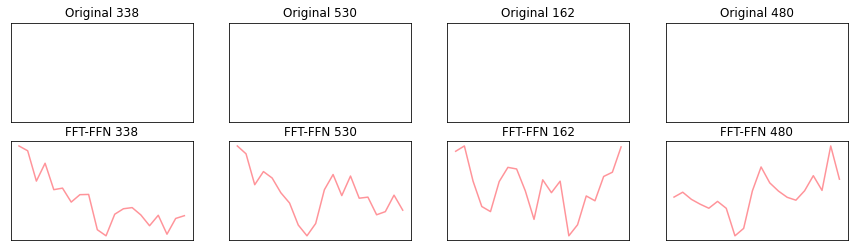

In [103]:
# Plot n random sequences (Actuals &)

n = 4
plt.figure(figsize=(15, 4))

for i in range(n):
    i_index = np.random.randint(0, 1283)
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.plot(X_total[i_index], color="#56B9FF")
    plt.title(f"Original {i_index}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(y_pred[i_index],  color="#FF949A")
    plt.title(f"FFT-FFN {i_index}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()